In [15]:
import numpy as np
import qnm_filter
import qnm
import random
import argparse
from scipy.special import logsumexp
from pathlib import Path
import matplotlib.pyplot as pl
import glob
from gwpy.timeseries import TimeSeries
import h5py
import matplotlib
mplparams = {
    'text.usetex': True,
    'axes.linewidth': 1,
    'lines.linewidth' : 1.5,
    'axes.grid': False,
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 26,
    'figure.figsize': (15, 12),
    'legend.fontsize': 26,
    'legend.handlelength' : 2,
    'legend.numpoints' : 1,
    'axes.grid' : True,
    'grid.alpha' : 0.9,
}
matplotlib.rcParams.update(mplparams)

red = '#D60606'
blue = '#0083DE'
green = '#00BA75'
yellow = '#FFC61E'
purple = '#A433B3'
orange = '#FD882E'
color_arr = [red, blue, green, yellow, purple, orange]

In [29]:
delta_mass = 0.5
delta_chi = 0.01
massspace = np.arange(45, 130, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)
duration = 4
fsamp = 4096*1
injection = {'mass' : 70,
            'chi' : 0.7}

In [17]:
def signal_creator(noise_scale):
    global signal_inj, mass, t_range, signalH_noise, signalL_noise, mass_in_solar, chi_inject
    # Remnant properties
    mass_in_solar = injection['mass']
    chi_inject = injection['chi']
    injected = (mass_in_solar, chi_inject)
    mass = qnm_filter.Filter.mass_unit(injected[0]) #unit of time
    
    # Complex frequency of the modes
    omega_dict = {}
    for mode in modes_inj:
        if mode == 'None': pass
        else: omega_dict[mode] = qnm.modes_cache(s=-2,l=int(mode[0]),m=int(mode[1]),n=int(mode[2]))(a=injected[1])[0]


    amp = 8.4 * 1e-21
    t_range = np.arange(-duration/2, duration/2, 1/fsamp)
    idx = abs(t_range)>8
    
    # Creating the signal
    signal_inj = np.zeros(len(t_range))
    for keys, omega in omega_dict.items():
        phase = 0
        temp_signal = np.real(amp * np.exp(1j*phase) * np.exp(-1j * omega * np.abs(t_range / mass)))
        temp_signal[idx] = 0
        signal_inj = np.add(signal_inj, temp_signal)
    
    ifo_H1 = qnm_filter.set_bilby_predefined_ifo(
    "H1", fsamp, duration, start_time=-duration / 2)
    signalH_noise = noise_scale*qnm_filter.bilby_get_strain(ifo_H1, 0.0)
    ifo_L1 = qnm_filter.set_bilby_predefined_ifo(
    "L1", fsamp, duration, start_time=-duration / 2)
    signalL_noise = noise_scale*qnm_filter.bilby_get_strain(ifo_L1, 0.0)

In [132]:
def white_contour():
    modes_inj = [(2,2,0)]
    modes_filt = [(2,2,0),(2,2,1)]
    signal_creator(0)

    fit = qnm_filter.Network(segment_length=0.2, srate=fsamp, t_init=3.0*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal_inj+signalH_noise, index=t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', trim=False, remove_mean=False)
    fit.compute_acfs('original_data')
    temp_acf = np.full(fsamp, 0, dtype = np.double)
    temp_acf[0] = 1e-43
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()
    if modes_inj == ['None']: 
        model_list_inj = None
        SNRtot_MF = 0
    else: 
        model_list_inj = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_inj]
        fit.pure_nr = {}
        fit.pure_nr["H1"] = qnm_filter.RealData(signal_inj, index=t_range, ifo="H1")
        fit.condition_data('pure_nr', trim=False, remove_mean=False)
        SNRtot_MF = fit.compute_SNR(
            fit.truncate_data(fit.original_data)["H1"],
            fit.truncate_data(fit.pure_nr)["H1"],
            "H1",
            False,
        )
    print(f"SNR = {SNRtot_MF}")
    model_list_filt = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_filt]

    likelihood_inj, evidence_inj = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 6,
                                                 model_list=model_list_inj)
    likelihood_filt, evidence_filt = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 6, 
                                                 model_list=model_list_filt)
    credible_inj = qnm_filter.find_credible_region(likelihood_inj)
    credible_filt = qnm_filter.find_credible_region(likelihood_filt)
    return likelihood_inj, likelihood_filt, credible_inj, credible_filt, evidence_inj, evidence_filt

In [144]:
def injection_contour():
    modes_inj = [(2,2,0)]
    modes_filt = [(2,2,0),(2,2,1)]
    signal_creator(2.21)

    fit = qnm_filter.Network(segment_length=0.2, srate=fsamp, t_init=3.0*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal_inj+signalH_noise, index=t_range)
    fit.detector_alignment()
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(signalH_noise, index=t_range)
    fit.condition_data('original_data', trim=False, remove_mean=False)
    fit.condition_data('pure_noise', trim=False, remove_mean=False)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    if modes_inj == ['None']: 
        model_list_inj = None
        SNRtot_MF = 0
    else: 
        model_list_inj = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_inj]
        fit.pure_nr = {}
        fit.pure_nr["H1"] = qnm_filter.RealData(signal_inj, index=t_range, ifo="H1")
        fit.condition_data('pure_nr', trim=False, remove_mean=False)
        SNRtot_MF = fit.compute_SNR(
            fit.truncate_data(fit.original_data)["H1"],
            fit.truncate_data(fit.pure_nr)["H1"],
            "H1",
            False,
        )
    print(f"SNR = {SNRtot_MF}")
    model_list_filt = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_filt]

    likelihood_inj, evidence_inj = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 6,
                                                 model_list=model_list_inj)
    likelihood_filt, evidence_filt = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 6, 
                                                 model_list=model_list_filt)
    credible_inj = qnm_filter.find_credible_region(likelihood_inj)
    credible_filt = qnm_filter.find_credible_region(likelihood_filt)
    return likelihood_inj, likelihood_filt, credible_inj, credible_filt, evidence_inj, evidence_filt

In [133]:
white_results = white_contour()

SNR = 43.291390248042774


In [145]:
injection_results = []
for i in range(3):
    injection_results.append(injection_contour())

SNR = 44.655370009654696
SNR = 43.99840405155534
SNR = 44.41040711908094


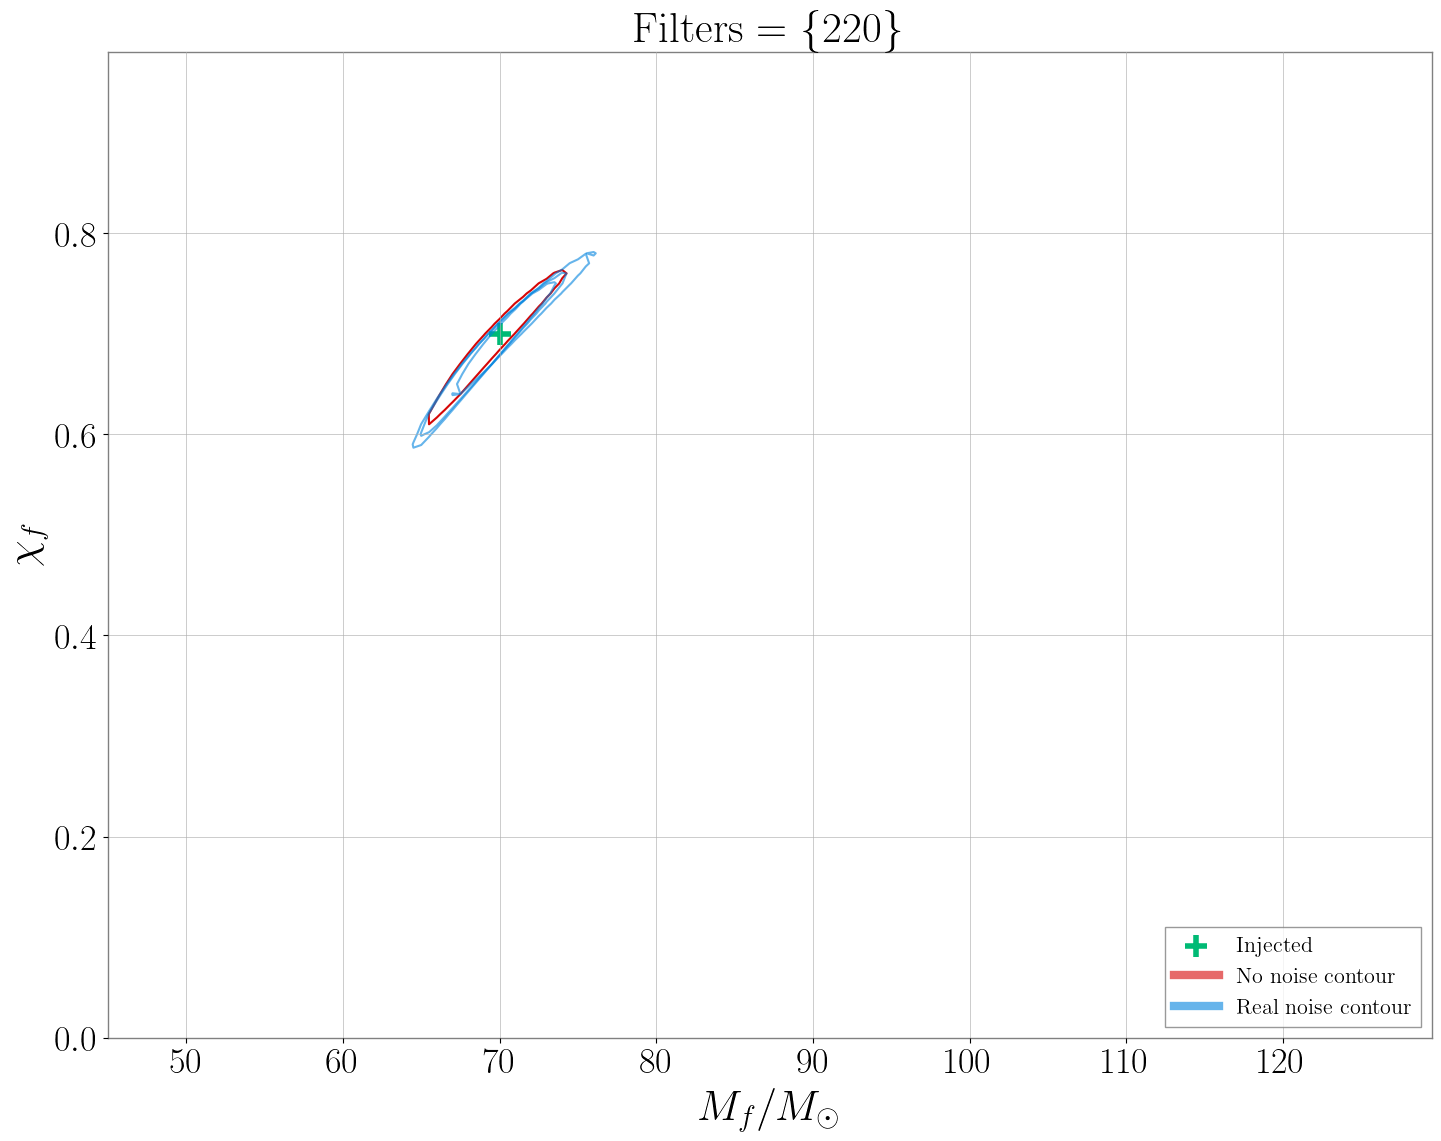

In [146]:
pl.rc('figure')
fig, ax = pl.subplots()

ax.scatter(x=70, y=0.7, s=255, marker='+', c=green, linewidths=4, label='Injected')
likelihood_inj, likelihood_filt, credible_inj, credible_filt, evidence_inj, evidence_filt = white_results
ax.contour(mass_grid, chi_grid, likelihood_inj, [credible_inj], colors=red, 
                           linestyles='-')

for result in injection_results:
    likelihood_inj, likelihood_filt, credible_inj, credible_filt, evidence_inj, evidence_filt = result
    white_contour = ax.contour(mass_grid, chi_grid, likelihood_inj, [credible_inj], colors=blue, 
                               alpha=0.6, linestyles='-')
ax.plot(np.nan, np.nan, color=red, alpha=0.6, ls='-', label='No noise contour')
ax.plot(np.nan, np.nan, color=blue, alpha=0.6, ls='-', label='Real noise contour')
    
pl.legend(loc='lower right', fontsize = 16)
pl.xlabel(r'$M_f/M_\odot$')
pl.ylabel(r'$\chi_f$')
pl.title("Filters = \{220\}")
pl.tight_layout()

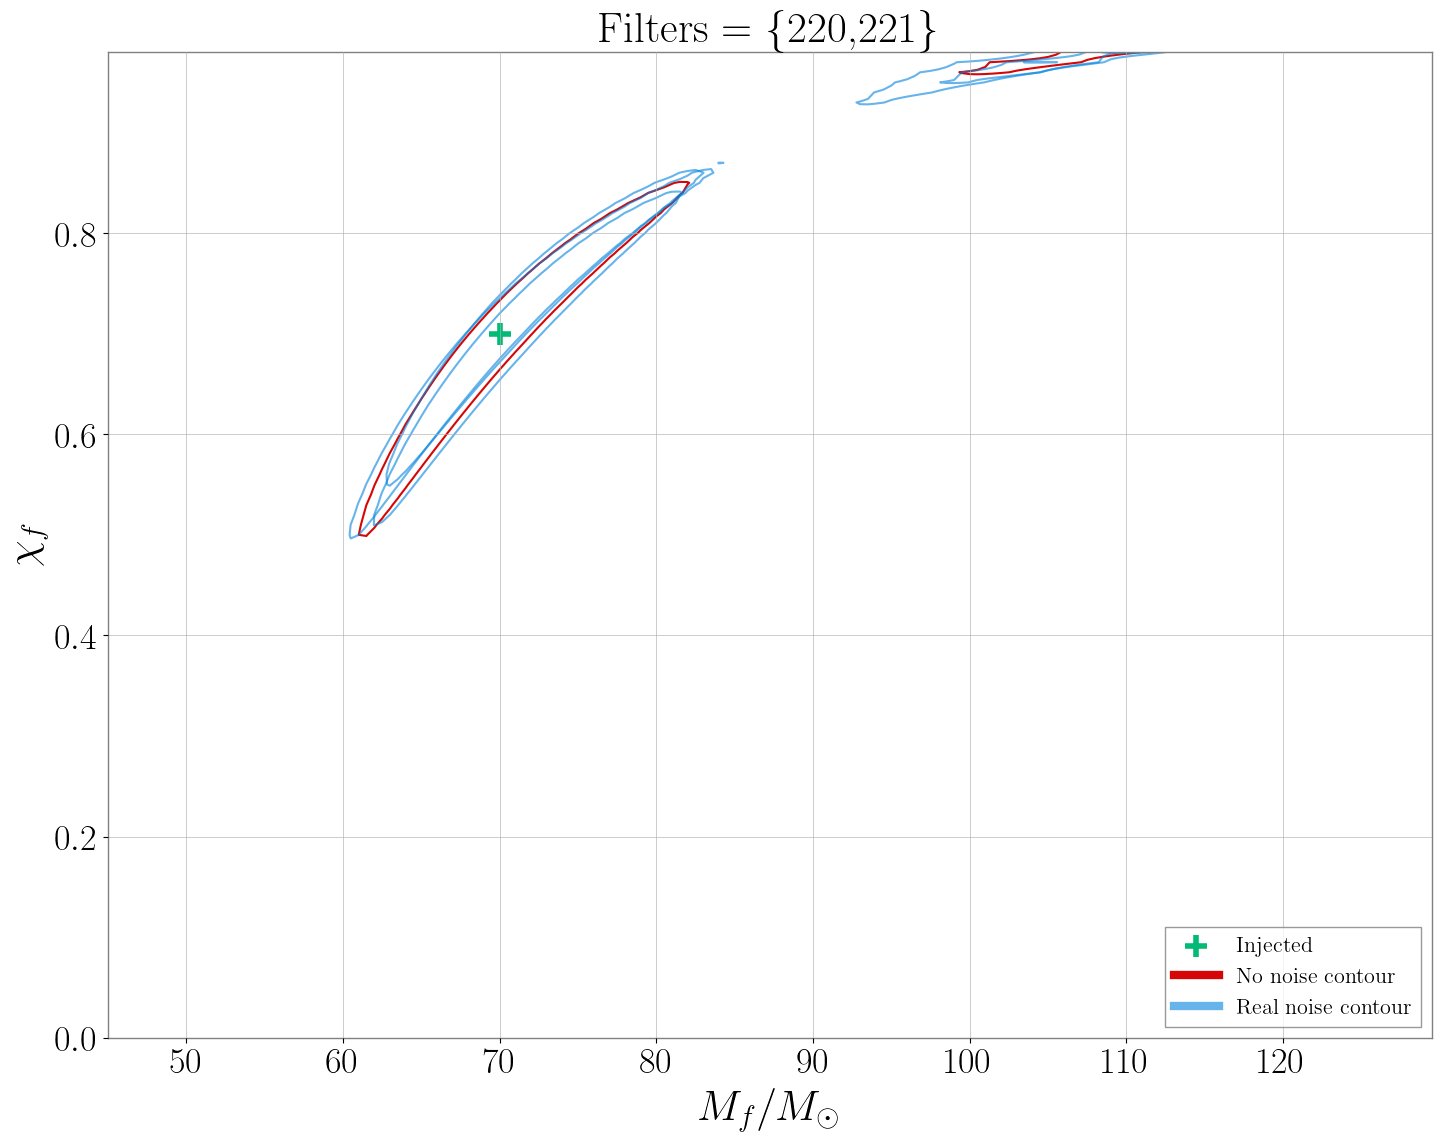

In [147]:
pl.rc('figure')
fig, ax = pl.subplots()

ax.scatter(x=70, y=0.7, s=255, marker='+', c=green, linewidths=4, label='Injected')
likelihood_inj, likelihood_filt, credible_inj, credible_filt, evidence_inj, evidence_filt = white_results
ax.contour(mass_grid, chi_grid, likelihood_filt, [credible_filt], colors=red, 
                           linestyles='-')

for result in injection_results:
    likelihood_inj, likelihood_filt, credible_inj, credible_filt, evidence_inj, evidence_filt = result
    white_contour = ax.contour(mass_grid, chi_grid, likelihood_filt, [credible_filt], colors=blue, 
                               alpha=0.6, linestyles='-')
ax.plot(np.nan, np.nan, color=red, alpha=1, ls='-', label='No noise contour')
ax.plot(np.nan, np.nan, color=blue, alpha=0.6, ls='-', label='Real noise contour')
    
pl.legend(loc='lower right', fontsize = 16)
pl.xlabel(r'$M_f/M_\odot$')
pl.ylabel(r'$\chi_f$')
pl.title("Filters = \{220,221\}")
pl.tight_layout()

In [30]:
modes_inj = [(2,2,0)]
modes_filt = [(2,2,0),(2,2,1)]
signal_creator(6)

fit = qnm_filter.Network(segment_length=0.2, srate=fsamp, t_init=3.0*mass)
fit.original_data['H1'] = qnm_filter.RealData(signal_inj+signalH_noise, index=t_range)
fit.detector_alignment()
fit.pure_noise = {}
fit.pure_noise['H1'] = qnm_filter.RealData(signalH_noise, index=t_range)
fit.condition_data('original_data', trim=False, remove_mean=False)
fit.condition_data('pure_noise', trim=False, remove_mean=False)
fit.compute_acfs('pure_noise')
fit.cholesky_decomposition()
fit.first_index()
if modes_inj == ['None']: 
    model_list_inj = None
    SNRtot_MF = 0
else: 
    model_list_inj = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_inj]
    fit.pure_nr = {}
    fit.pure_nr["H1"] = qnm_filter.RealData(signal_inj, index=t_range, ifo="H1")
    fit.condition_data('pure_nr', trim=False, remove_mean=False)
    SNRtot_MF = fit.compute_SNR(
        fit.truncate_data(fit.original_data)["H1"],
        fit.truncate_data(fit.pure_nr)["H1"],
        "H1",
        False,
    )
print(f"SNR = {SNRtot_MF}")
model_list_filt = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_filt]

likelihood_inj, evidence_inj = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 6,
                                             model_list=model_list_inj)
likelihood_filt, evidence_filt = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 6, 
                                             model_list=model_list_filt)
credible_inj = qnm_filter.find_credible_region(likelihood_inj)
credible_filt = qnm_filter.find_credible_region(likelihood_filt)

SNR = 17.436037689093894


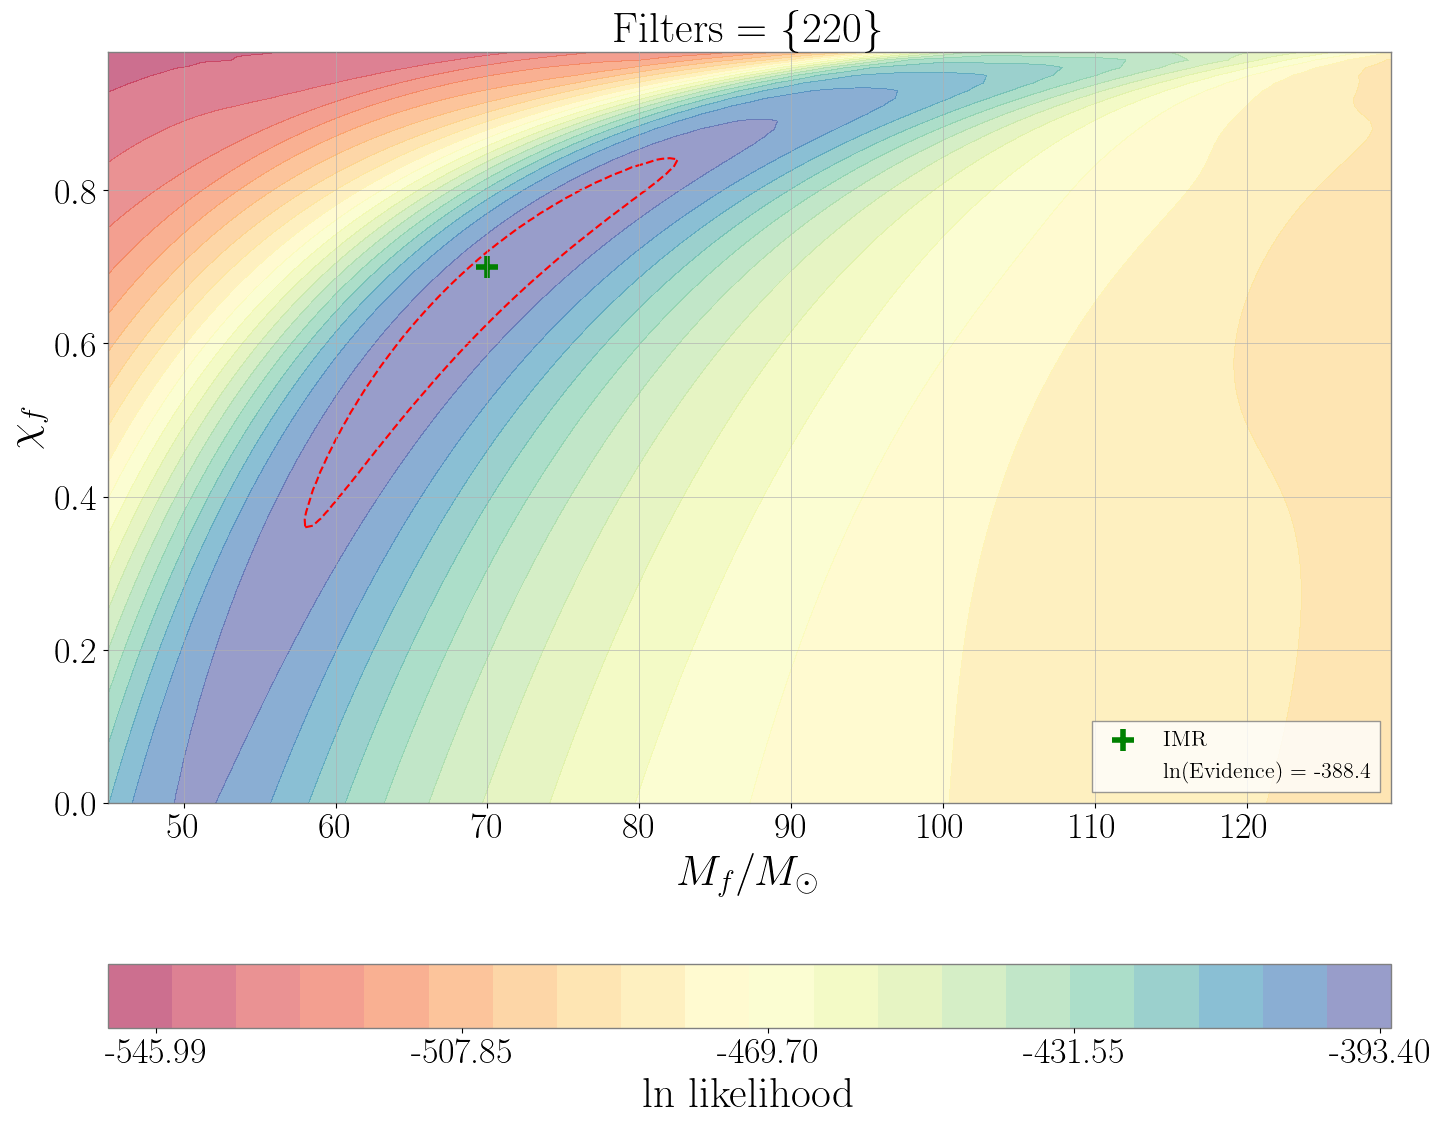

In [31]:
pl.rc('figure')
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_inj, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_inj, [credible_inj], colors='red',
                    linestyles='--')
ax.scatter(x=70, y=0.7, s=255, marker='+',
           c='g', linewidths=4, label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none',
        label='ln(Evidence) = %.1F' % evidence_inj)

cbar = fig.colorbar(contours, orientation="horizontal",
                    pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood')
cbar.set_ticks(np.linspace(np.min(likelihood_inj),
               np.max(likelihood_inj), 5))

pl.legend(loc='lower right', fontsize = 16)
pl.xlabel(r'$M_f/M_\odot$')
pl.ylabel(r'$\chi_f$')
pl.title("Filters = \{220\}")
pl.tight_layout()

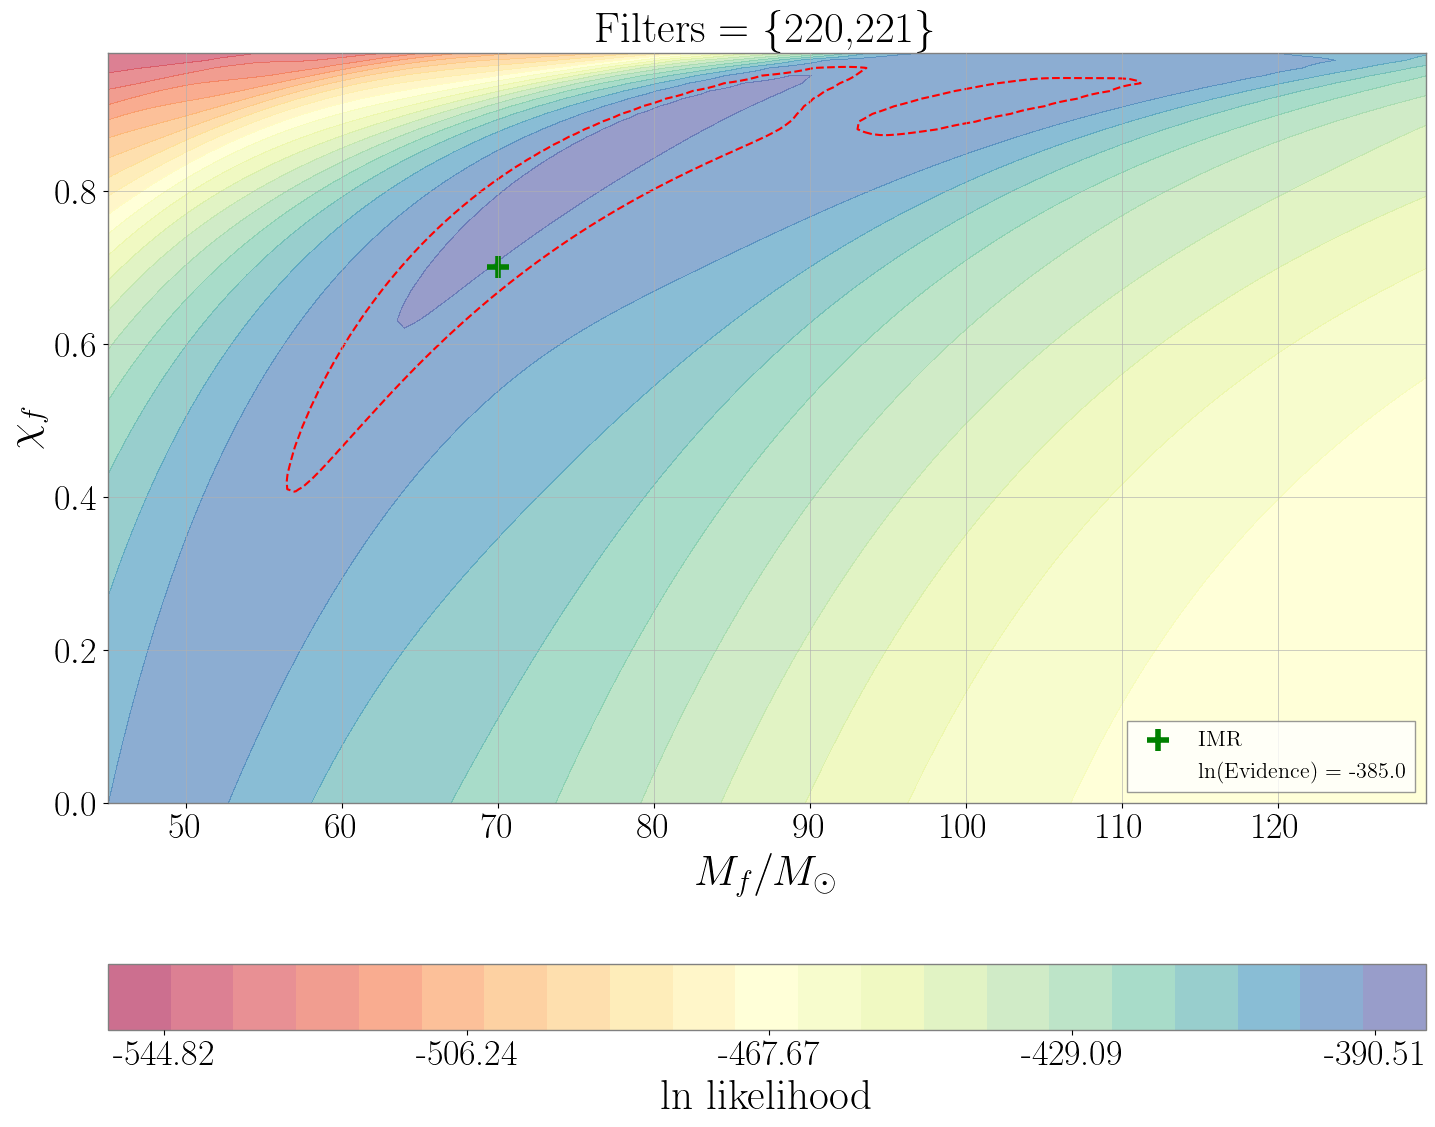

In [32]:
pl.rc('figure')
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_filt, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_filt, [credible_filt], colors='red',
                    linestyles='--')
ax.scatter(x=70, y=0.7, s=255, marker='+',
           c='g', linewidths=4, label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none',
        label='ln(Evidence) = %.1F' % evidence_filt)

cbar = fig.colorbar(contours, orientation="horizontal",
                    pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood')
cbar.set_ticks(np.linspace(np.min(likelihood_filt),
               np.max(likelihood_filt), 5))

pl.legend(loc='lower right', fontsize = 16)
pl.xlabel(r'$M_f/M_\odot$')
pl.ylabel(r'$\chi_f$')
pl.title("Filters = \{220,221\}")
pl.tight_layout()

In [71]:
import ringdown as rd
results = []
levels = [dotted]
for i in levels:
    temp0 = []
    for j in i.collections[0].get_paths():
        coords = j.vertices
        temp1 = [(rd.qnms.get_ftau(k[0], k[1], l=2,m=2,n=0),
               rd.qnms.get_ftau(k[0], k[1], l=2,m=2,n=1)) for k in coords]
#         temp1.append(temp1[0])
        temp0.append(temp1)
    results.append(temp0)
injected_ftau = rd.qnms.get_ftau(injection['mass'], injection['chi'], l=2,m=2,n=0)

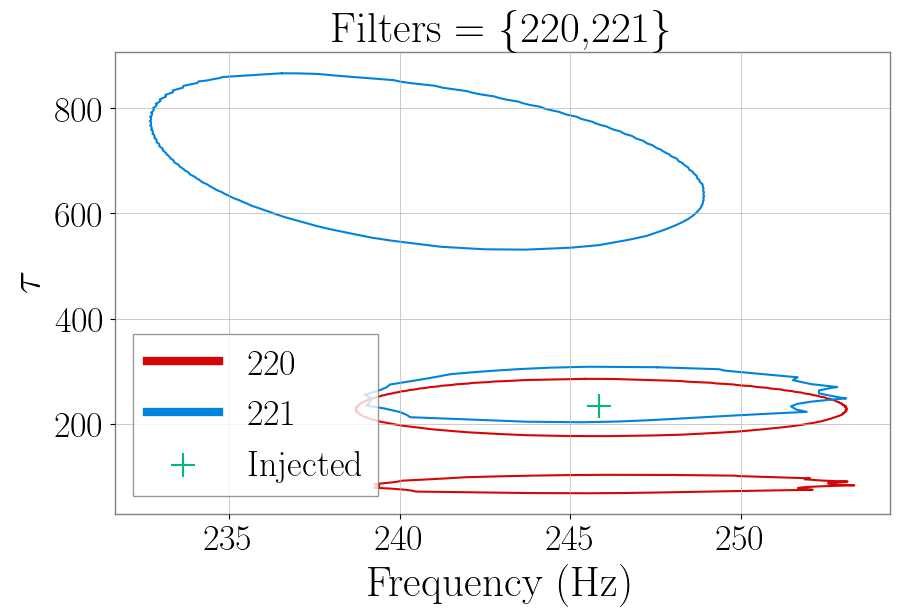

In [100]:
pl.figure(figsize=(10, 6))
for idx, i in enumerate(results):
    for j in i:
        temp = np.array(j)
        pl.plot(temp[:,0,0], 1/temp[:,0,1], c=red)
        pl.plot(temp[:,1,0], 1/temp[:,1,1], c=blue)
#         axs[1].plot(temp[:,2,0], 1/temp[:,2,1], c='blue', ls=ls_arr[idx])
#         axs[1].plot(temp[:,3,0], 1/temp[:,3,1], c='orange', ls=ls_arr[idx])

l, = pl.plot([], [], c=red, label='220')
l, = pl.plot([], [], c=blue, label='221')
pl.scatter(injected_ftau[0], 1/injected_ftau[1], marker='+', color=green, s=300, label="Injected")
pl.xlabel("Frequency (Hz)")
pl.ylabel(r"$\tau$")
pl.title("Filters = \{220,221\}")
pl.legend(loc='lower left')